# Preprocessing and Feature Engineering

In this notebook I will create a clean dataset ready to model through feature engineering and standardization.

First load the data from EDA, and clean up any extraneous columns that will not be used in prediction.  Then I will split the data into predictors and target.

Next I will perform PCA to see the principal components of the data.  The principal components may be used as input to the modelling phase. 

Finally I will perform a train-test split and apply a basic logistic regression model to the data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
random_seed = 27

In [3]:
train = pd.read_csv('train_w_aggregated_weather.csv',index_col=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    4616 non-null   object 
 1   Trap                    4616 non-null   object 
 2   Address                 4616 non-null   object 
 3   Block                   4616 non-null   int64  
 4   Street                  4616 non-null   object 
 5   AddressNumberAndStreet  4616 non-null   object 
 6   Latitude                4616 non-null   float64
 7   Longitude               4616 non-null   float64
 8   AddressAccuracy         4616 non-null   int64  
 9   RESTUANS                4616 non-null   int64  
 10  PIPIENS                 4616 non-null   int64  
 11  SALINARIUS              4616 non-null   int64  
 12  TERRITANS               4616 non-null   int64  
 13  TARSALIS                4616 non-null   int64  
 14  ERRATICUS               4616 non-null   

In [4]:
### drop mosquito species columns, won't have that for predicting 
train = train.drop(['RESTUANS','PIPIENS','SALINARIUS','TERRITANS',\
                    'TARSALIS','ERRATICUS'],axis=1)

In [5]:
### Drop extraneous columns that won't be used in modeling
train = train.drop(['Date','Trap','Address','Block','Street',\
                    'AddressNumberAndStreet','Latitude','Longitude',\
                   'AddressAccuracy','Station'],axis=1)

In [6]:
### Drop CodeSum string columns
train = train.drop(['CodeSum_3days','CodeSum_7days','CodeSum_14days']\
                   ,axis=1)

In [7]:
### Finally drop the year column and number of mosquitos
train = train.drop(['Year','NumMosquitos'],axis=1)

In [8]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   WnvPresent            4616 non-null   float64
 1   Month                 4616 non-null   int64  
 2   Week                  4616 non-null   int64  
 3   Station_dist          4616 non-null   float64
 4   Tmax_3days            4616 non-null   float64
 5   Tmin_3days            4616 non-null   float64
 6   Tavg_3days            4616 non-null   float64
 7   PrecipTotal_3days     4616 non-null   float64
 8   DewPoint_3days        4616 non-null   float64
 9   WetBulb_3days         4616 non-null   float64
 10  StnPressure_3days     4616 non-null   float64
 11  SeaLevel_3days        4616 non-null   float64
 12  AvgSpeed_3days        4616 non-null   float64
 13  WindSpeed_3days       4616 non-null   float64
 14  WindDirection_3days   4616 non-null   float64
 15  Sunrise(hrs)_3days   

Looks great the data set is all numeric and there are no nulls to be found.  
___
I'll do a quick PCA now to see how many principal components are in my 48 columns of data.  

In [9]:
### Split predictors from target
y = train[['WnvPresent']]
X = train.drop('WnvPresent',axis=1)
X_cols = list(X.columns)

In [10]:
### Apply standard scaler to transform variable to mean=0 and std=1
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
#dum = pd.DataFrame(X_scaled,columns=X_cols)
#dum.mean()
#dum.std(ddof=0)

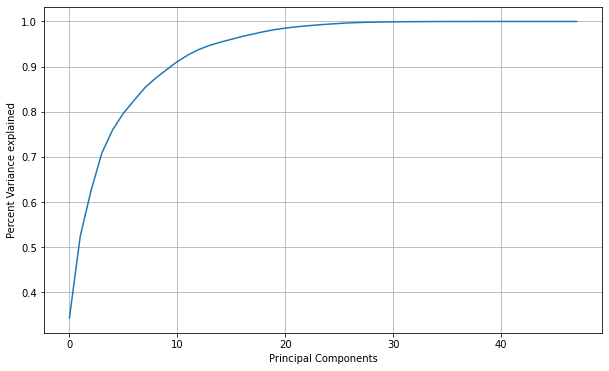

In [12]:
### Calculate PCA an plot percent variance explained

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
                      
plt.subplots(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Percent Variance explained')
plt.xlabel('Principal Components')
plt.grid(axis='both')
plt.show()

From the PCA it looks like ~9-10 principal components explain 90% of the variance.  During the modelling process I probably do not need more than 10 predictors in my model.  I will try NMF also to see if I can identify key columns in the NMF components.

Text(0.5, 1.0, 'Scatter plot of first 2 principal components\ncolored by negative(dark) or positive(light) WNV case')

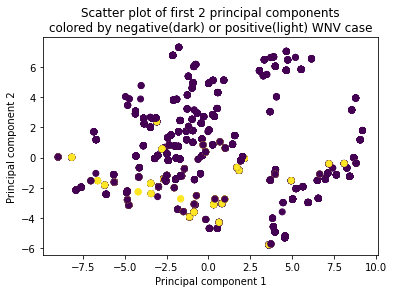

In [13]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=y.to_numpy());
plt.ylabel('Principal component 2')
plt.xlabel('Principal component 1')
plt.title('Scatter plot of first 2 principal components\ncolored by negative(dark) or positive(light) WNV case')

The first two principal components are starting to distinguish between negative and positive WNV cases.  

First I will apply a simple Logistic Regression model to predict the positive WNV cases. Then I will apply a Logistic Regression model to the top components of the PCA transformed data set.  

In [14]:
### Re-split the data set into X and y
y = train['WnvPresent']
X = train.drop('WnvPresent',axis=1)

In [15]:
y.shape

(4616,)

In [16]:
### Standardize dataset and split into training and testing sets for modeling.
from sklearn.model_selection import train_test_split

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)


### Stratify on y due to imbalanced data set
### I want equal propotions of positive cases in train and test
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=.2,\
                                                random_state = random_seed,
                                                stratify=y)


X_train_df = pd.DataFrame(X_train, columns = X_cols)
X_test_df = pd.DataFrame(X_test, columns = X_cols)



In [17]:
print('Testing Fraction positive:  {:.3f} '.format(y_test.sum()/y_test.shape[0]))
print('Training Fraction positive: {:.3f}'.format(y_train.sum()/y_train.shape[0]))

Testing Fraction positive:  0.083 
Training Fraction positive: 0.083


Split looks good. I will take a slight detour to export these data sets and a PCA(.95) data set with reduced dimensions.  

In [18]:
### Export out training and testing data for modeling


X_train_df.to_csv('X_train.csv')
X_test_df.to_csv('X_test.csv')

y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

pca = PCA(.95)
pca.fit(X_train) ### Fit only on the training data 
X_train_pca95 = pca.transform(X_train)
X_test_pca95 = pca.transform(X_test)

pd.DataFrame(X_train_pca95).to_csv('X_train_pca95.csv')
pd.DataFrame(X_test_pca95).to_csv('X_test_pca95.csv')

print('PCA reduced features: {}'.format(X_train_pca95.shape[1]))

PCA reduced features: 15


Next, I will perform a quick logistic regression here to see how predictive a basic model can be.  

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score,\
        plot_roc_curve, plot_precision_recall_curve, precision_recall_curve,\
        make_scorer, plot_confusion_matrix

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)


print('Training AUC:', roc_auc_score(y_train,logreg.predict_proba(X_train)[:,1] )) 
print('Testint AUC:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1] )) 

Training AUC: 0.8470053882287925
Testint AUC: 0.8155752158113433


That looks pretty good.  Now I will quickly try to improve this model with a little tuning

In [20]:
### Now a quick attempt at optimizing the logistic regression model using
### GridSearchCV and a little tweaking

from sklearn.model_selection import GridSearchCV

### define regularization strengths to try
Cs = [0.001, 0.01, .1, 1, 10, 10]
### define grid serch parameters
params = {'C':Cs,'max_iter':[500]}

gridcv_logreg = GridSearchCV(LogisticRegression(),param_grid=params,\
                             cv=5, scoring=make_scorer(roc_auc_score))
gridcv_logreg.fit(X_train,y_train)

print('Best Params:',gridcv_logreg.best_params_)
print('Best Params Score:',gridcv_logreg.best_score_)




Best Params: {'C': 10, 'max_iter': 500}
Best Params Score: 0.5132920617779347


In [21]:
### Create Logistic Regression model using best parameters
logreg = LogisticRegression(C=10,max_iter=500)
logreg.fit(X_train,y_train)

print('Training AUC:', roc_auc_score(y_train,logreg.predict_proba(X_train)[:,1] )) 
print('Testing AUC:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1] )) 

Training AUC: 0.8533943154953794
Testing AUC: 0.8236710161149358


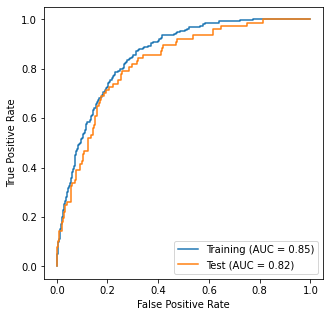

In [22]:
### Plot ROC curves for both training and testing sets using the
### best model derived from the grid search

fig, ax = plt.subplots(figsize=(5,5))
plot_roc_curve(logreg,X_train,y_train,ax=ax,name='Training')
plot_roc_curve(logreg,X_test,y_test, ax=ax,name = 'Test')
plt.show()

The ROC curves for training and testing look great, and the AUC score calculate in the plot is higher than I was expecting.  Let's take a look at the confusion matrix.   

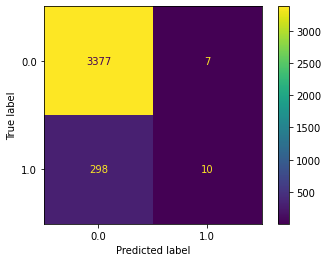

In [23]:
plot_confusion_matrix(logreg,X_train,y_train,values_format='.4g');

From this graphic I can calculate the precision and recall for this model.  

In [24]:
### Training data Precision and recall
print('Precision: {:.3f}'.format(10/(10+7)))
print('Recall:    {:.3f}'.format(10/(10+298)))

Precision: 0.588
Recall:    0.032


The recall score is very low.  There are a lot of true positive cases in the training set this modeling is failing to predict ( _false negatives_ ). 
___
Now lets look at the test set

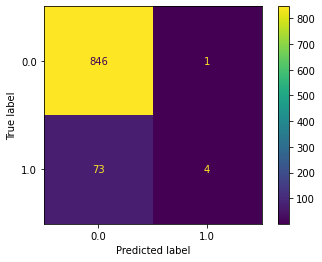

In [25]:
plot_confusion_matrix(logreg,X_test,y_test,values_format='.4g');

In [26]:
### Testing data precision and recall
print('Precision: {:.3f}'.format(4/(4+1)))
print('Recall:    {:.3f}'.format(4/(4+73)))

Precision: 0.800
Recall:    0.052


Again the recall is very low.

In [27]:
d={'Coeff':logreg.coef_.T.reshape(-1,), 'Col':X_cols}
pd.DataFrame(d).sort_values(by='Coeff',ascending=False).reset_index(drop=True)[:15]

,Coeff,Col
0,3.464459,Week
1,2.898683,Sunset(hrs)_3days
2,2.497186,WetBulb_3days
3,2.430816,SeaLevel_14days
4,2.299930,Tmin_7days
5,2.209799,Tavg_14days
6,1.832972,Sunset(hrs)_14days
7,1.662621,Sunrise(hrs)_14days
8,1.588756,WetBulb_7days
9,1.470475,Sunset(hrs)_7days


The above dataframe shows the Logistic Regression model coefficients for each column in the training set.  Since all of the columns are standardized 

___
For this project I need to improve upon the recall score.  I will attempt to do this in the next notebook where I will employ more advanced ML techniques.


# Summary

In this notebook, first I imported the cleaned and merged data set.  Next I dropped non-numeric and other extraneous columns that could not be used for prediction of the test set.  

I performed PCA on the data set and discovered that about 10 principal components explain 90% of th variance in the data.  I can use this information in the modelling process so that I do not over complicate the model. I created a PCA transform that explains 95% of the variance and it created a new dataset with 15 features.  I exported the transformed training and testing sets. 

Finally I split the data into training and testing sets, and applied a logistic regression to the training data set.  I used `GridSearchCV` to fit the model and then plotted the ROC curves for the training and testing data sets.  The AUC values for the training and test set were 0.85 & 0.82 respectiveley, but upon closer inspection the recall was extremely low for each.  I will attempt to improve upon this with more advanced ML techniques in the next notebook.

### Extra work reducing dimensionality with NMF

In [28]:
### For NMF scale features to [0,1]
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_minmax = minmax.fit_transform(X)


In [29]:
### Split into training and testing again
X_train,X_test,y_train,y_test = train_test_split(X_minmax, y, test_size=.2,\
                                                random_state = random_seed,
                                                stratify=y)

In [30]:
from sklearn.decomposition import NMF

nmf = NMF(15)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)

In [31]:
X_train_nmf.shape

(3692, 15)

In [32]:
nmf_comps = pd.DataFrame(nmf.components_,columns=X_cols)
nmf_comps.head()

,Month,Week,Station_dist,Tmax_3days,Tmin_3days,Tavg_3days,PrecipTotal_3days,DewPoint_3days,WetBulb_3days,StnPressure_3days,...,WindSpeed_14days,WindDirection_14days,Sunrise(hrs)_14days,Sunset(hrs)_14days,RA_7days,VC_7days,HZ_7days,FG_7days,TS_7days,BR_7days
0,0.793238,0.724543,0.000000,1.977413,2.148928,2.127158,0.0,1.914895,2.128724,0.586535,...,0.000000,0.641764,0.000000,1.782709,0.000000,0.0,0.0,0.0,0.237437,0.000000
1,3.294447,3.378265,0.000000,0.101051,0.008324,0.012180,0.0,0.000000,0.000000,1.608430,...,0.000000,0.510772,3.454231,0.000000,0.035927,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.381321,0.178879,0.196987,0.0,0.000000,0.000000,0.301276,...,1.935413,0.000000,0.000000,1.541920,0.113648,0.0,0.0,0.0,0.190679,0.000000
3,0.000000,0.182862,0.281155,0.000000,0.634783,0.001412,0.0,1.630723,0.883436,0.000000,...,0.002435,0.199740,0.295240,0.000000,2.525950,0.0,0.0,0.0,0.000000,5.529829
4,0.529978,0.411466,0.000000,0.201886,0.266753,0.213634,0.0,0.000000,0.096806,4.172930,...,0.024736,0.491445,0.000000,1.223217,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [33]:
for i in range(nmf_comps.shape[0]):
    print(nmf_comps.iloc[i].sort_values(ascending=False)[:3])
    print()
    

WetBulb_14days     3.011942
DewPoint_14days    2.921824
Tavg_14days        2.809516
Name: 0, dtype: float64

Sunrise(hrs)_3days     3.530037
Sunrise(hrs)_7days     3.520504
Sunrise(hrs)_14days    3.454231
Name: 1, dtype: float64

StnPressure_14days    1.997625
WindSpeed_14days      1.935413
SeaLevel_14days       1.842564
Name: 2, dtype: float64

BR_7days               5.529829
RA_7days               2.525950
WindDirection_3days    1.687182
Name: 3, dtype: float64

SeaLevel_3days       4.280527
StnPressure_3days    4.172930
SeaLevel_7days       4.064374
Name: 4, dtype: float64

WindDirection_3days     4.832971
WindDirection_7days     3.912617
WindDirection_14days    3.244196
Name: 5, dtype: float64

VC_7days             4.494653
TS_7days             2.143895
Sunset(hrs)_3days    1.284591
Name: 6, dtype: float64

Tmax_3days        1.594644
WetBulb_3days     1.578911
DewPoint_3days    1.566831
Name: 7, dtype: float64

Station_dist      10.127475
SeaLevel_3days     0.353863
SeaLevel_7days 

The above shows the 3 biggest components for each new NMF feature.
___
I will export out these datasets for modeling efforts also.

In [34]:
### transform test set also
X_test_nmf = nmf.transform(X_test)

pd.DataFrame(X_train_nmf).to_csv('X_train_nmf.csv')
pd.DataFrame(X_test_nmf).to_csv('X_test_nmf.csv')